In [ ]:
!unzip test.csv.zip -d ./
!unzip train.csv.zip -d ./
!rm -rfv test.csv.zip
!rm -rfv train.csv.zip

# all uploaded zip files will be unzipped, so do not worry about that matter.

Archive:  test.csv.zip
  inflating: ./test.csv              
Archive:  train.csv.zip
  inflating: ./train.csv             
removed 'test.csv.zip'
removed 'train.csv.zip'


In [ ]:
### Steps:

# Encoding (pandas)
## Preprocessing (MinMaxScaler)
### Imbalancing (SMOTE)
#### Model used (Random Forest with log_loss criteria)
##### All reports printed (sklearn.metrics)

### Voting used with combination of all followed models:
# AdaBoost, XGBoost, SVM, Random Forest, MLP (TF), LogisticRegression
# with Bagging

### Random Forest itself gave the best result.
### CPU runtime utilization recommended as these libraries do not support TPU/GPU.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv('mushroom.csv')
df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [ ]:
df['class'] = df['class'].map({'e': 0, 'p': 1}) # converting e to 0, p to 1 in class column
df = df.drop(columns=df.columns[df.isnull().sum() > 100]).drop('id', axis=1) # dropping all columns whose null values is more than 100
df = df.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'object' else col) # encoding
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df = df.dropna()
df.head()

,class,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,habitat,season
0,0.0,0.108755,0.729730,0.935897,0.346154,0.952381,0.050834,0.149563,0.949153,0.260870,0.500000,0.000000
1,1.0,0.055556,0.972973,0.833333,0.346154,0.746032,0.053990,0.062974,0.813559,0.826087,0.500000,1.000000
2,0.0,0.085689,0.729730,0.641026,0.346154,0.952381,0.077209,0.096501,0.796610,0.260870,0.711538,1.000000
3,0.0,0.047743,0.729730,0.743590,0.346154,0.603175,0.046889,0.063460,0.949153,0.260870,0.500000,0.666667
4,0.0,0.072173,0.972973,0.961538,0.346154,0.952381,0.037985,0.081244,0.949153,0.260870,0.576923,0.000000


In [ ]:
df_subset = df.sample(n=300000, random_state=42) # 300k samples selected and SMOTE applied for imbalance
X = df_subset.drop('class', axis=1)
y = df_subset['class']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, criterion='log_loss', n_jobs=-1) #verbose=2
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_resampled)
print(classification_report(y_resampled, y_pred))
print("Accuracy:", accuracy_score(y_resampled, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    163771
         1.0       1.00      1.00      1.00    163771

    accuracy                           1.00    327542
   macro avg       1.00      1.00      1.00    327542
weighted avg       1.00      1.00      1.00    327542

Accuracy: 1.0


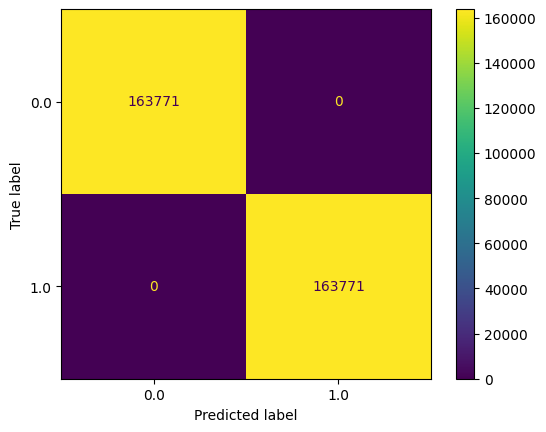

In [ ]:
cm = confusion_matrix(y_resampled, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()